In [1]:
import cv2
import mediapipe as mp
import numpy as np
import json
import time
import math
import matplotlib.pyplot as plt

In [2]:
class OneEuroFilter:
    def __init__(self, min_cutoff=1.0, beta=0.0):
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.x_prev = 0
        self.dx_prev = 0
        self.t_prev = 0

    def smoothing_factor(self, t_e, cutoff):
        r = 2 * math.pi * cutoff * t_e
        return r / (r + 1)

    def exponential_smoothing(self, a, x, x_prev):
        return a * x + (1 - a) * x_prev

    def filter(self, t, x):
        t_e = t - self.t_prev
        self.dx = (x - self.x_prev) / t_e if t_e > 0 else 0
        cutoff = self.min_cutoff + self.beta * abs(self.dx)
        a = self.smoothing_factor(t_e, cutoff)
        x_filtered = self.exponential_smoothing(a, x, self.x_prev)
        self.x_prev = x_filtered
        self.dx_prev = self.dx
        self.t_prev = t
        return x_filtered

In [3]:
print("GET READY! Recording in 3 seconds...")
time.sleep(3)
print("RECORDING... Move head: 3s Still, 3s Moving.")

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)
cap = cv2.VideoCapture(0)

raw_data = []
timestamps = []
start_time = time.time()

while True:
    elapsed = time.time() - start_time
    if elapsed > 6.0: break
    
    success, image = cap.read()
    if not success: break
    
    image = cv2.flip(image, 1)

    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        nose_x = results.multi_face_landmarks[0].landmark[1].x
        raw_data.append(nose_x)
        timestamps.append(elapsed)
        
        h, w, _ = image.shape
        cx, cy = int(nose_x * w), int(results.multi_face_landmarks[0].landmark[1].y * h)
        cv2.circle(image, (cx, cy), 5, (0, 255, 0), -1)

    cv2.imshow('Recording Data...', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() 
print(f"Recorded {len(raw_data)} frames.")

GET READY! Recording in 3 seconds...
RECORDING... Move head: 3s Still, 3s Moving.


C:\Users\angel\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Recorded 153 frames.


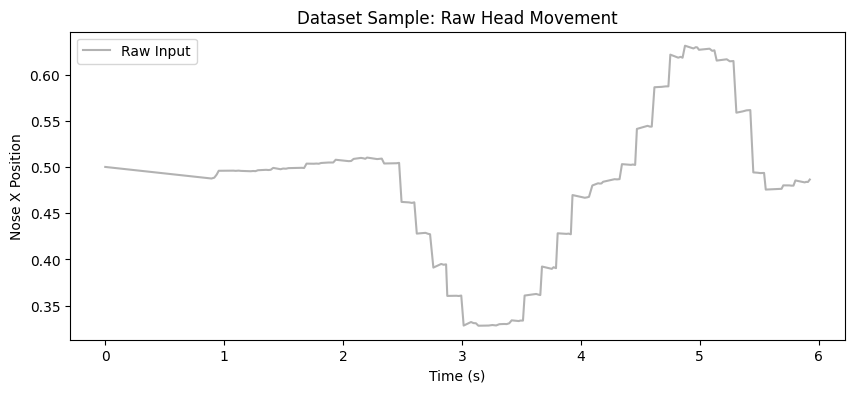

In [4]:
plt.figure(figsize=(10,4))
plt.plot(timestamps, raw_data, label='Raw Input', color='gray', alpha=0.6)
plt.title("Dataset Sample: Raw Head Movement")
plt.xlabel("Time (s)")
plt.ylabel("Nose X Position")
plt.legend()
plt.savefig('images/dataset_sample.png')
plt.show()

In [5]:
betas = [0.0, 0.01, 0.05, 0.1, 1.0]
jitter_scores = []
lag_scores = []

for b in betas:
    f = OneEuroFilter(beta=b)
    filtered = []
    for i, x in enumerate(raw_data):
        filtered.append(f.filter(timestamps[i], x))
    
    jitter = np.std(np.diff(filtered[:20])) 
    lag = np.mean(np.abs(np.array(raw_data) - np.array(filtered)))
    
    jitter_scores.append(jitter)
    lag_scores.append(lag)

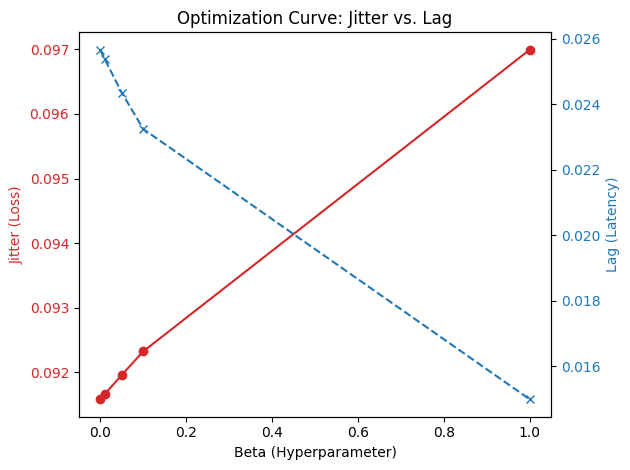

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Beta (Hyperparameter)')
ax1.set_ylabel('Jitter (Loss)', color=color)
ax1.plot(betas, jitter_scores, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Lag (Latency)', color=color)
ax2.plot(betas, lag_scores, color=color, marker='x', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Optimization Curve: Jitter vs. Lag")
plt.tight_layout()
plt.savefig('images/loss_curve.png')
plt.show()

In [7]:
best_beta = 0.05
weights = {"parameters": {"min_cutoff": 1.0, "beta": best_beta}}
with open('filter_weights.json', 'w') as f:
    json.dump(weights, f, indent=4)
print("Files generated: dataset_sample.png, loss_curve.png, filter_weights.json")

Files generated: dataset_sample.png, loss_curve.png, filter_weights.json
